In [7]:
import torch, re, numpy as np, pandas as pd
from transformers import AutoTokenizer, AutoModel, EsmModel
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from typing import List, Dict
import torch.nn.functional as F

from stream_train_sae import SimpleSAE, build_esm, esm_layer_hidden_states


In [8]:
import torch
from stream_train_sae import SimpleSAE, build_esm, esm_layer_hidden_states

# Load the trained SAE
checkpoint_path = "/home/ec2-user/SageMaker/InterPLM/checkpoints_large/sae_step_5000.pt"  # Replace with your checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cuda')

# Get config and create SAE
config = checkpoint['config']
sae = SimpleSAE(
    d_in=config['d_hidden'],
    n_feats=config['n_feats'],
    tied=False
).cuda()

# Load the trained weights
sae.load_state_dict(checkpoint['sae_state_dict'])
sae.eval()

print(f"Loaded SAE from step {checkpoint['step']}")
print(f"Dictionary size: {config['n_feats']}")
print(f"Hidden dim: {config['d_hidden']}")

# Load ESM model for getting embeddings
model, tokenizer = build_esm()

# Test on a single sequence
test_seq = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"

# Get ESM embeddings
with torch.no_grad():
    # Get hidden states from ESM
    hiddens, mask = esm_layer_hidden_states([test_seq], model, tokenizer)
    
    # Flatten and prepare for SAE
    x = hiddens[mask].float()  # [N_tokens, 1280]
    
    # Pass through SAE
    x_reconstructed, z = sae(x)
    
    # Calculate metrics
    recon_error = F.mse_loss(x_reconstructed, x).item()
    sparsity = (z > 0).float().mean().item()
    n_active = (z > 0).sum(dim=1).float().mean().item()
    
print(f"\nTest Results:")
print(f"Reconstruction MSE: {recon_error:.6f}")
print(f"Sparsity (% active): {sparsity:.3%}")
print(f"Avg active features per token: {n_active:.1f}")

Loaded SAE from step 5000
Dictionary size: 10240
Hidden dim: 1280


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Test Results:
Reconstruction MSE: 7.341561
Sparsity (% active): 12.102%
Avg active features per token: 1239.2


In [3]:
plm_model = "esm2-650m"
plm_layer = 24          
# sae = load_sae_from_hf(plm_model=plm_model, plm_layer=plm_layer).to(device).eval()
sae = "/home/ec2-user/SageMaker/InterPLM/checkpoints_large/sae_step_5000.pt"


In [4]:
print(sae)

AutoEncoder(
  (encoder): Linear(in_features=1280, out_features=10240, bias=True)
  (decoder): Linear(in_features=10240, out_features=1280, bias=False)
)


In [6]:
seqs = {
    "Ab_H": "EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMHWVRQAPGKGLEWVSYISSGSSSYIYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARGLGGFGDYWGQGTLVTVSS",
}


## Get hidden states & SAE features (per residue)



In [9]:
@torch.no_grad()
def esm_layer_reps(seq: str):
    t = tokenizer(seq, return_tensors="pt", add_special_tokens=True).to(device)
    out = model(**t)
    h = out.hidden_states[plm_layer][0] #(L+2, d), [0] to get rid of the batch dimension so its normally (B, L+2, d) where d= 1280
    print(h.shape)
    return h[1:-1] #strip CLS/EOS -> (L,d)

@torch.no_grad()
def sae_features(h): #H: (L,d)
    f = sae.encode(h) #L, Ddict), roughly in [0, 1], sparse
    h_rec = sae.decode(f)
    err = h - h_rec #useful for steering later? hm
    return f, h_rec, err

features_per_seq : Dict[str, torch.Tensor] = {}
lengths = {}

for name, seq in seqs.items():
    h = esm_layer_reps(seq)
    f, _, _ = sae_features(h)
    features_per_seq[name] = f #(L, D)
    lengths[name] = len(seq)

D = next(iter(features_per_seq.values())).shape[1]
print("Dictorionary size(features):", D)


torch.Size([120, 1280])
Dictorionary size(features): 10240


In [10]:
esm_layer_reps(seqs["Ab_H"])

torch.Size([120, 1280])


tensor([[-10.4504,  19.4505,  11.3402,  ...,  -0.3911,  -0.9232,   1.8859],
        [ -6.1209,  10.2938,   2.9786,  ...,  -1.9253,   5.5663,  -1.6059],
        [ -5.1847,   6.1780,  -0.3910,  ...,   2.2540,  -0.6244,  -1.6850],
        ...,
        [ -5.8453,  20.0732,  -0.6450,  ..., -10.4917,  -7.0448,   0.5548],
        [ -1.0779,  21.0717,   4.8077,  ...,  -5.9967,   0.1423,   4.9940],
        [  4.7114,  19.3804,   9.1147,  ..., -16.4988,   3.1150,   1.7367]],
       device='cuda:0')

## Summarize features

In [12]:
def pool_features(f):
    return torch.cat([f.mean(0), f.max(0).values]) #(2D,)
X_rows, names = [], []

for name, f in features_per_seq.items():
    X_rows.append(pool_features(f).cpu().numpy())
    names.append(name)

X = np.vstack(X_rows) #shape (N, 2D)

df_top = pd.DataFrame(index=names)

#list each sequences top-10 features by mean activation
topk = 10
for i, name in enumerate(names):
    mean_feats = X[i, :D]
    top_ids = np.argsort(mean_feats)[::-1][:topk]
    df_top.loc[name, "top_features"] = ", ".join([f"f/{int(j)}:{mean_feats[j]:.2f}" for j in top_ids])
df_top

,top_features
Ab_H,"f/4574:0.62, f/1061:0.16, f/6756:0.14, f/3162:..."
Ab_L,"f/4574:0.67, f/1061:0.18, f/6756:0.13, f/3162:..."
Collagen_like,"f/5933:0.33, f/2816:0.26, f/6819:0.23, f/59:0...."
His_rich,"f/602:0.26, f/5724:0.25, f/3948:0.22, f/1524:0..."
NGlyc,"f/3772:0.42, f/9936:0.30, f/4129:0.28, f/9872:..."
CysPair,"f/9824:0.46, f/3130:0.30, f/5724:0.21, f/7819:..."


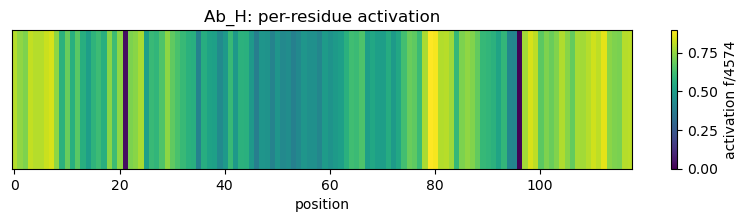

In [14]:
import matplotlib.pyplot as plt
def plot_feature_heatmap(name: str, feat_id: int):
    f = features_per_seq[name] #(L, D)
    a = f[:, feat_id].cpu().numpy() #(L, )
    plt.figure(figsize=(10,1.8))
    plt.imshow(a[None,:], aspect="auto")
    plt.yticks([])
    plt.colorbar(label=f"activation f/{feat_id}")
    plt.title(f"{name}: per-residue activation")
    plt.xlabel("position")
    plt.show()
# example: plot the top feature for Ab_H
first_top = int(df_top.loc["Ab_H","top_features"].split(",")[0].split("/")[1].split(":")[0])
plot_feature_heatmap("Ab_H", first_top)

In [15]:
def has_nglyc(s:str): return re.search(r"N[^P][ST]", s) is not None
def has_cyspair(s:str): return re.search(r"C.{0,20}C", s) is not None
def his_rich(s:str): return s.count("H") >= 6
def gly_periodic(s:str): return re.search(r"G..G..G", s) is not None

labels = pd.DataFrame({
    "name": names,
    "nglyc": [has_nglyc(seqs[n]) for n in names],
    "cys_pair": [has_cyspair(seqs[n]) for n in names],
    "his_rich": [his_rich(seqs[n]) for n in names],
    "gly_periodic": [gly_periodic(seqs[n]) for n in names],
}).set_index("name")
labels

,nglyc,cys_pair,his_rich,gly_periodic
name,,,,
Ab_H,False,False,False,False
Ab_L,False,False,False,False
Collagen_like,False,False,False,True
His_rich,False,False,True,False
NGlyc,True,False,False,False
CysPair,False,True,False,False


In [16]:
meanX = X[:, :D] #sequence-level mean activation (N, D)

def feature_screen_auc(y_bool):
    y = y_bool.astype(int)
    aucs = []
    for j in range(D):
        scores = meanX[:, j]

        if len(np.unique(y)) < 2 or len (np.unique(scores)) < 2:
            aucs.append(np.nan)
        else:
            aucs.append(roc_auc_score(y, scores))
    return np.array(aucs)
screen = {}

for col in ["nglyc", "cys_pair", "his_rich", "gly_periodic"]:
    aucs = feature_screen_auc(labels[col].values)
    top = np.argsort(np.nan_to_num(aucs, nan=-1))[::-1][:10]
    screen[col] = [(int(j), aucs[j]) for j in top]
screen #shows top feature IDs & AUCs per concept

{'nglyc': [(6184, 1.0),
  (6192, 1.0),
  (10181, 1.0),
  (6247, 1.0),
  (77, 1.0),
  (7810, 1.0),
  (3792, 1.0),
  (1, 1.0),
  (3807, 1.0),
  (7820, 1.0)],
 'cys_pair': [(10214, 1.0),
  (7819, 1.0),
  (7822, 1.0),
  (10199, 1.0),
  (10197, 1.0),
  (2904, 1.0),
  (2902, 1.0),
  (9322, 1.0),
  (2938, 1.0),
  (2935, 1.0)],
 'his_rich': [(45, 1.0),
  (10180, 1.0),
  (3935, 1.0),
  (6213, 1.0),
  (3884, 1.0),
  (7685, 1.0),
  (3835, 1.0),
  (6221, 1.0),
  (6291, 1.0),
  (6287, 1.0)],
 'gly_periodic': [(54, 1.0),
  (59, 1.0),
  (6454, 1.0),
  (7998, 1.0),
  (10158, 1.0),
  (179, 1.0),
  (6451, 1.0),
  (3740, 1.0),
  (49, 1.0),
  (6328, 1.0)]}

In [19]:
def mini_probe(target: str, k: int=16):
    y = labels[target].astype(int).values
    auc = feature_screen_auc(y)
    top = np.argsort(np.nan_to_num(aucs, nan=-1))[::-1][:k]
    X_probe = meanX[:, top]
    if len (np.unique(y)) <2:
        return None, None, top
    clf = LogisticRegression(max_iter=1000)
    auc = cross_val_score(clf, X_probe, y, cv=min(5, len(y)), scoring="roc_auc").mean()
    return auc, top, top

for target in ["nglyc","cys_pair","his_rich","gly_periodic"]:
    auc, top, _ = mini_probe(target, k=8)
    print(f"{target}: AUC={auc} | top_feats={top}")

/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packag

nglyc: AUC=nan | top_feats=[   54    59  6454  7998 10158   179  6451  3740]


/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packag

cys_pair: AUC=nan | top_feats=[   54    59  6454  7998 10158   179  6451  3740]


/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packag

his_rich: AUC=nan | top_feats=[   54    59  6454  7998 10158   179  6451  3740]
gly_periodic: AUC=nan | top_feats=[   54    59  6454  7998 10158   179  6451  3740]


/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packag